# RegNet：网络结构设计的新范式 —— 创新点总结

**RegNet（Regularized Network）** 是 Facebook AI 提出的一种新型网络结构设计方法，旨在探索更高效、更通用的神经网络架构。它不仅在性能上优于传统的网络（如 ResNet、EfficientNet 等），更重要的是其设计理念带来了架构搜索领域的范式转变。

## 1. 从“手工设计”到“设计空间建模”

传统网络设计依赖专家经验手动调整层数、通道数等参数，而 RegNet 提出了一种新的思路：将神经网络结构抽象为**设计空间（Design Space）**，并通过统计方法建模和优化这一空间。

- **核心思想**：不是设计单个网络，而是设计一个网络结构的“分布”或“族”。
- **方法**：使用简单统计模型（如线性回归）分析大量随机网络的性能，找出影响性能的关键因素。

## 2. 线性变化的块宽度（Block Width）

RegNet 发现，**网络中各阶段（stage）的块宽度（即通道数）应线性增长**，而不是像 ResNet 那样指数增长或固定。

- 通过大量实验验证，线性增长的宽度在精度与效率之间取得了更好的平衡。
- 这一发现简化了网络设计，也提升了模型的泛化能力。

## 3. 统一的网络结构模板

RegNet 提出了一种**通用的网络结构模板（Template）**，该模板由以下三个关键参数控制：

- **深度（Depth）**：网络的总层数。
- **宽度（Width）**：初始通道数及增长方式。
- **组宽（Group Width）**：每个卷积块的分组宽度（如使用分组卷积）。

这种模板使得 RegNet 可以灵活地适应不同计算预算（FLOPs），生成多个子模型（如 RegNetY、RegNetX 等）。

## 4. 简单但高效的结构

RegNet 摒弃了复杂的模块设计（如 SE 模块、多分支结构），采用**统一的瓶颈块结构**（Bottleneck Block）和**分组卷积（Grouped Convolution）**，在保持高效的同时提升了性能。

## 5. 可扩展性强

基于设计空间建模，Facebook 提出了多个 RegNet 变体，包括：

- **RegNetX**：使用分组卷积，注重精度与效率平衡。
- **RegNetY**：加入 SE 注意力机制，提升精度。

## 6. 可解释性强的设计原则

RegNet 通过统计建模，总结出了一些**可解释的设计原则**，例如：

- 更深的网络不一定更好，深度与宽度需平衡。
- 分组卷积的组宽对性能有显著影响，存在最优值。
- 宽度线性增长比指数增长更优。

这些原则不仅指导了 RegNet 的设计，也为后续网络架构搜索提供了理论依据。

---

## 总结

| 创新点             | 描述                                                         |
|--------------------|--------------------------------------------------------------|
| 设计空间建模       | 将网络结构设计转化为统计建模问题                             |
| 线性宽度增长       | 不同阶段通道数线性增长                                       |
| 模块化模板         | 用三个参数统一控制网络结构                                   |
| 简洁高效           | 使用简单瓶颈块和分组卷积                                     |
| 可扩展性强         | 支持多种变体适应不同场景                                     |
| 可解释性强         | 提出可验证、可复用的设计原则                                 |

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory

train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=None,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=None,
)

In [ ]:
from hdd.data_util.auto_augmentation import ImageNetPolicy

from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader
from hdd.models.cnn.regnet import create_regnet
from hdd.train.classification_utils import (
    naive_train_classification_model,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    net,
    train_dataloader,
    val_dataloader,
    lr=1e-3,
    weight_decay=1e-3,
    max_epochs=100,
) -> dict[str, list[float]]:
    print(f"#Parameter: {count_trainable_parameter(net)}")
    criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, max_epochs, eta_min=lr / 100
    )
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return training_stats


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader


# 我们提前计算好了训练数据集上的均值和方差
TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]

stats = {}
net_names = ["regnet_y_400mf", "regnet_y_800mf"]
batch_sizes = [64, 32]
for net_name, batch_size in zip(net_names, batch_sizes):
    net = create_regnet(net_name)
    net = net.to(DEVICE)
    train_dataset_transforms = transforms.Compose(
        [
            RandomResize([256, 288, 320, 352]),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            ImageNetPolicy(),
            transforms.ToTensor(),
            transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
        ]
    )
    train_dataset.transform = train_dataset_transforms
    val_dataset_transforms = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
        ]
    )
    val_dataset.transform = val_dataset_transforms
    train_dataloader, val_dataloader = build_dataloader(
        batch_size, train_dataset, val_dataset
    )
    print(f"-----------------------{net_name}------------------------")
    max_epochs = 150
    stats[net_name] = train_net(
        net,
        train_dataloader,
        val_dataloader,
        lr=0.001,
        weight_decay=0,
        max_epochs=max_epochs,
    )
    del net

-----------------------regnet_y_400mf------------------------
#Parameter: 4344144
Epoch: 1/150 Train Loss: 3.0874 Accuracy: 0.2007 Time: 7.09031  | Val Loss: 2.9240 Accuracy: 0.3302
Epoch: 2/150 Train Loss: 2.7402 Accuracy: 0.3397 Time: 6.67413  | Val Loss: 2.6695 Accuracy: 0.4176
Epoch: 3/150 Train Loss: 2.5836 Accuracy: 0.4064 Time: 6.71223  | Val Loss: 2.3641 Accuracy: 0.5027
Epoch: 4/150 Train Loss: 2.4618 Accuracy: 0.4625 Time: 6.72344  | Val Loss: 2.0725 Accuracy: 0.6176
Epoch: 5/150 Train Loss: 2.3652 Accuracy: 0.4918 Time: 6.69325  | Val Loss: 2.0164 Accuracy: 0.6461
Epoch: 6/150 Train Loss: 2.3065 Accuracy: 0.5224 Time: 6.64050  | Val Loss: 2.0366 Accuracy: 0.6196
Epoch: 7/150 Train Loss: 2.2193 Accuracy: 0.5494 Time: 6.74367  | Val Loss: 2.1001 Accuracy: 0.6079
Epoch: 8/150 Train Loss: 2.1652 Accuracy: 0.5821 Time: 6.70320  | Val Loss: 1.8678 Accuracy: 0.7039
Epoch: 9/150 Train Loss: 2.1154 Accuracy: 0.5915 Time: 6.67888  | Val Loss: 1.7983 Accuracy: 0.7241
Epoch: 10/150 Trai

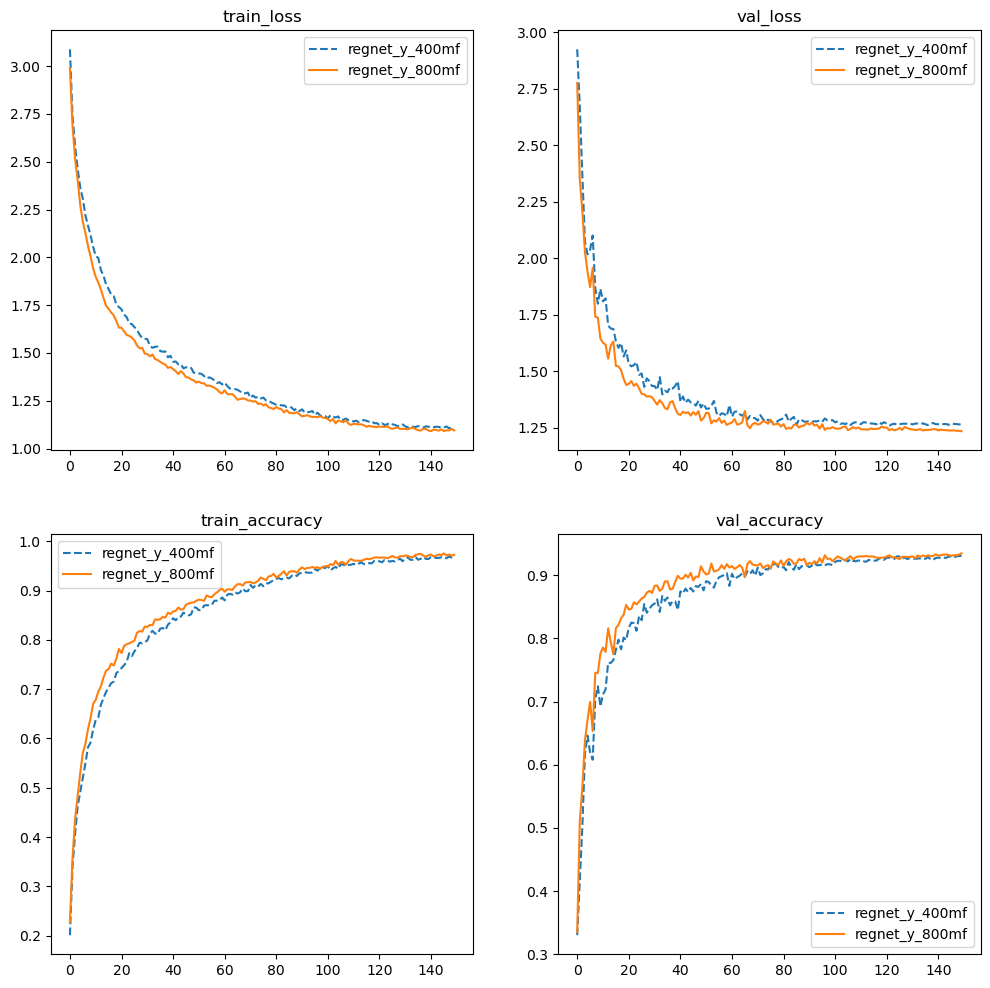

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = stats[net_names[0]].keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(stats[net_names[0]][field], label=net_names[0], linestyle="--")
    plt.plot(stats[net_names[1]][field], label=net_names[1])
    plt.legend()
    plt.title(field)